# So in explore_SLFV_GP.ipynb, I tried a bunch of different things on a VERY big lightcurve. But I think I'm getting ahead of myself, so I'm gonna take a step back here...

In [1]:
import numpy as np
import pandas as pd
from TESStools import *
import os
import warnings
from multiprocessing import Pool, cpu_count
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import h5py as h5

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
from pymc3_ext.utils import eval_in_model
import arviz as az

import exoplanet

print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1'


In [2]:
from aesara_theano_fallback import __version__ as tt_version
from celerite2 import __version__ as c2_version
pm.__version__, pmx.__version__, tt_version, c2_version

('3.11.4', '0.1.0', '0.0.4', '0.2.0')

# Ok here is our example data we're going to be working with. It's almost two years of TESS observations, with a year in between them

In [5]:
cool_sgs = pd.read_csv('sample.csv',index_col=0)
example = cool_sgs[cool_sgs['CommonName']=='HD 269953']
tic = example.index[0]
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'].values, lc['Flux'].values, lc['Err'].values

# Let's parse the lightcurve into TESS Sectors.

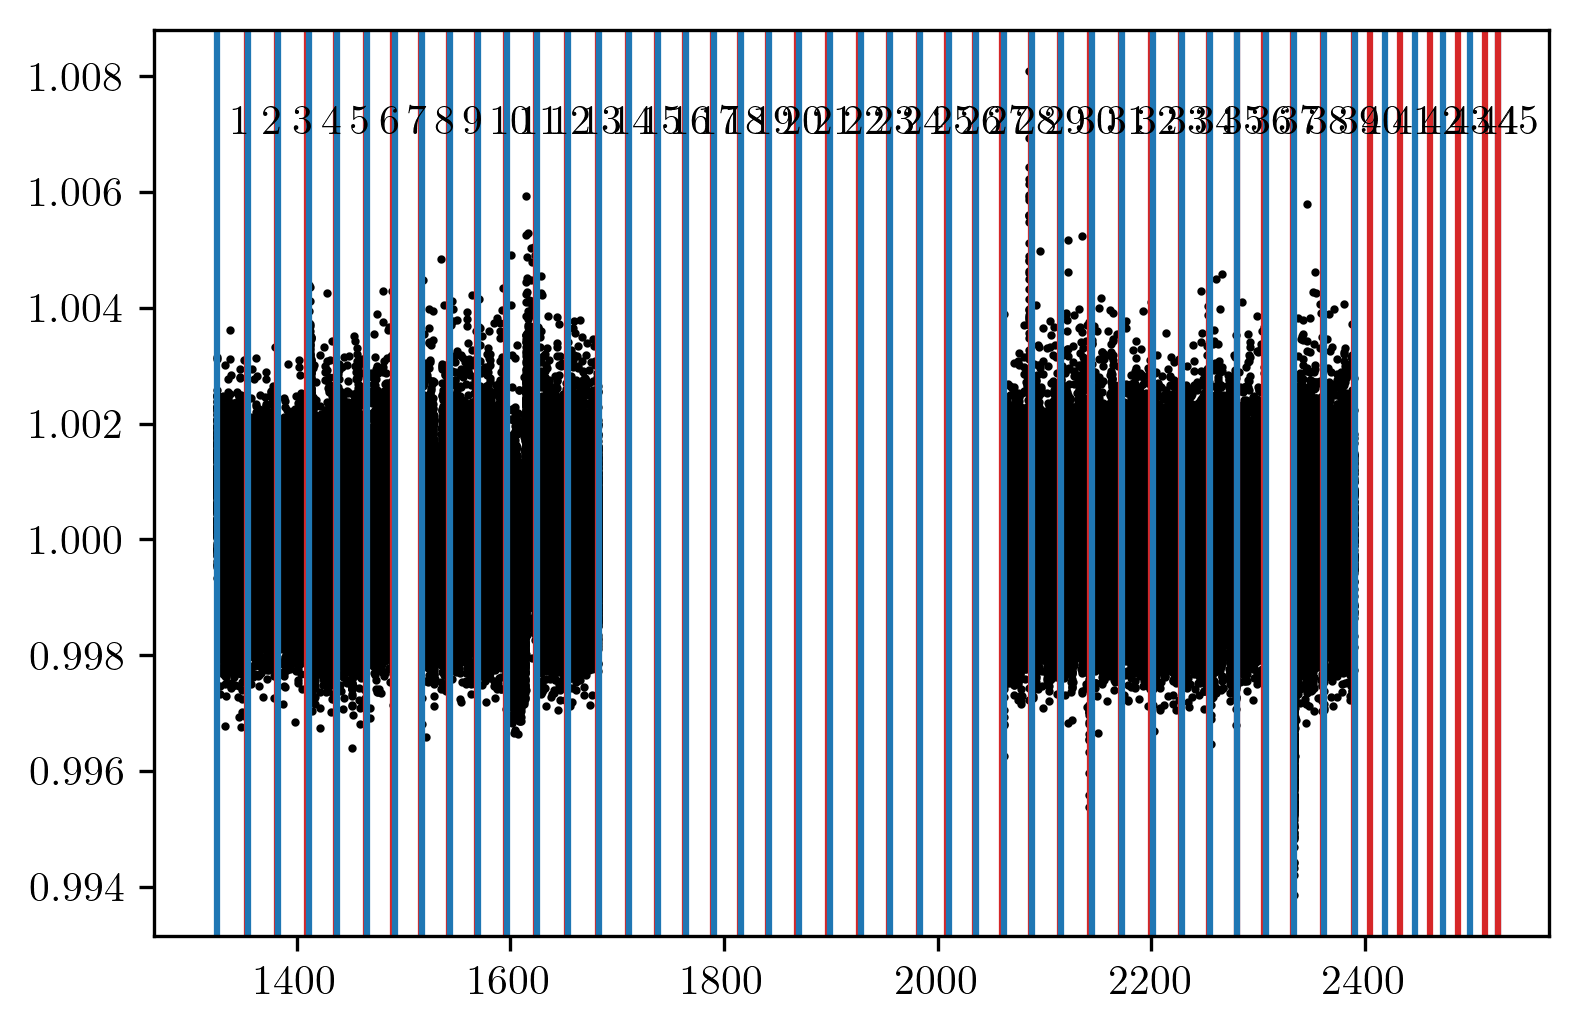

In [30]:
orbit_times = pd.read_csv('../data/orbit_times_20210629_1340.csv',skiprows=5)

sector_group = orbit_times.groupby('Sector')
sector_starts = sector_group['Start TJD'].min()
sector_ends = sector_group['End TJD'].max()
sectors = pd.DataFrame({'Sector':sector_starts.index,'Start TJD':sector_starts.values,'End TJD':sector_ends.values})

fig = plt.figure(dpi=300)
plt.scatter(time, flux, s=1, c='k')
for i,row in sectors.iterrows():
    plt.axvline(x=row['Start TJD'], c='C0')
    plt.axvline(x=row['End TJD'], c='C3')
    plt.text(0.5*(row['Start TJD']+row['End TJD']),1.007,int(row['Sector']))

In [50]:
sector_lcs = []
for i,row in sectors.iterrows():
    sec_lc = lc[(lc['Time']>=row['Start TJD'])&(lc['Time']<=row['End TJD'])]
    if len(sec_lc) > 0:
        sec_lc.insert(3,'Sector',np.tile(int(row['Sector']),len(sec_lc)))
        sector_lcs.append(sec_lc)
lc_new = pd.concat(sector_lcs)
lc_new

,Time,Flux,Err,Sector
77917,1325.309981,1.001858,0.000707,1
77918,1325.311370,1.000275,0.000707,1
77919,1325.312759,1.000209,0.000707,1
77920,1325.314148,1.001169,0.000707,1
77921,1325.315537,1.000812,0.000707,1
...,...,...,...,...
347374,2389.712263,0.999273,0.000690,39
347375,2389.713652,0.998131,0.000690,39
347376,2389.715041,0.998883,0.000690,39
347377,2389.716430,1.000033,0.000690,39


In [52]:
all_sectors = np.unique(lc_new['Sector'])
this_sector = lc_new[lc_new['Sector'] == all_sectors[0]]
this_sector

,Time,Flux,Err,Sector
77917,1325.309981,1.001858,0.000707,1
77918,1325.311370,1.000275,0.000707,1
77919,1325.312759,1.000209,0.000707,1
77920,1325.314148,1.001169,0.000707,1
77921,1325.315537,1.000812,0.000707,1
...,...,...,...,...
96181,1353.171031,0.999387,0.000707,1
96182,1353.172420,1.000280,0.000707,1
96183,1353.173809,1.000760,0.000707,1
96184,1353.175198,1.001018,0.000707,1


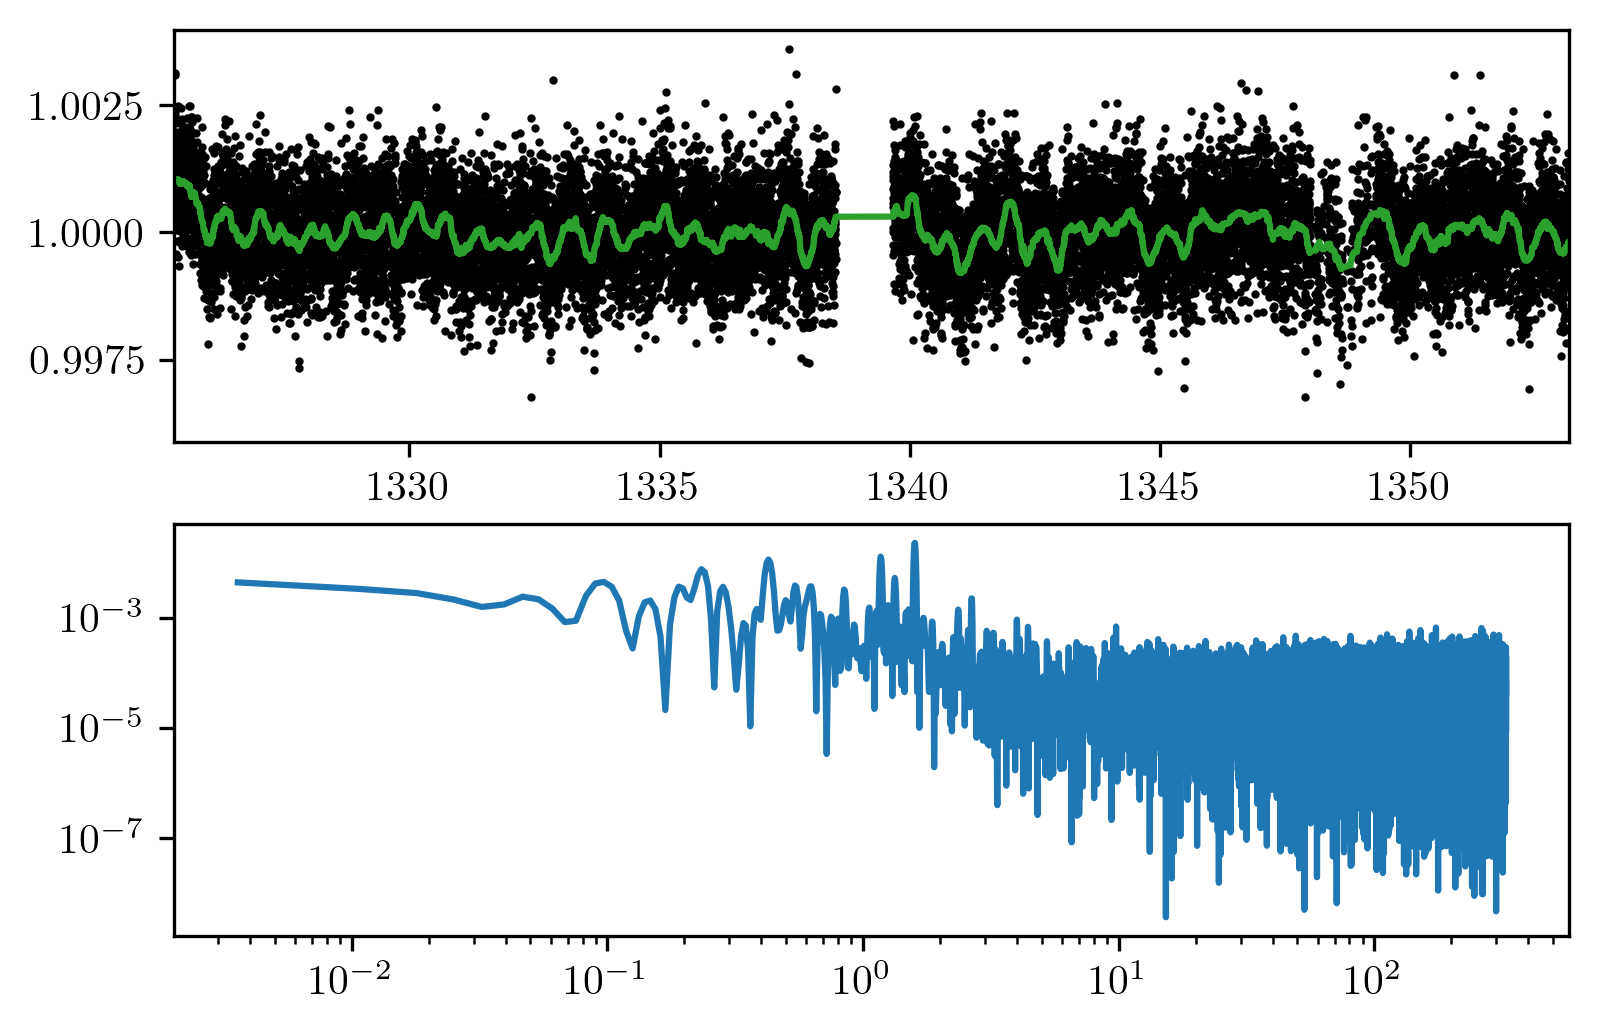

In [54]:
this_time, this_flux, this_err = this_sector['Time'].values, this_sector['Flux'].values, this_sector['Err'].values
pseudo_NF = 0.5 / (np.mean(np.diff(this_time)))
rayleigh = 1.0 / (this_time.max() - this_time.min())
ls = LombScargle(this_time,this_flux,dy=this_err,)
freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
power /= len(this_time)

fig, ax = plt.subplots(2, 1, dpi=300)

ax[0].scatter(this_time, this_flux,s=1,c='k')
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'],c='C2')
ax[0].set(xlim=(this_time.min(),this_time.max()))

ax[1].loglog(freq, power)

# Let's fit the GP to this!

In [55]:
# Here's a cute function that does that, but the mean can be any number of sinusoids!
def pm_fit_gp_sin(time, flux, err, fs=None, amps=None, phases=None, model=None, return_var=False, thin=50):
    """
    Use PyMC3 to do a maximum likelihood fit for a GP + multiple periodic signals
    
    Inputs
    ------
    time : array-like
        Times of observations
    flux : array-like
        Observed fluxes
    err : array-like
        Observational uncertainties    
    fs : array-like, elements are PyMC3 distributions
        Array with frequencies to fit, default None (i.e., only the GP is fit)
    amps : array-like, elements are PyMC3 distributions
        Array with amplitudes to fit, default None (i.e., only the GP is fit)
    phases : array-like, elements are PyMC3 distributions
        Array with phases to fit, default None (i.e., only the GP is fit)
    model : `pymc3.model.Model`
        PyMC3 Model object, will fail unless given
    return_var : bool, default True
        If True, returns the variance of the GP
    thin : integer, default 50
        Calculate the variance of the GP every `thin` points.
        
    Returns
    -------
    map_soln : dict
        Contains best-fit parameters and the gp predictions
    logp : float
        The log-likelihood of the model
    bic : float
        The Bayesian Information Criterion, -2 ln P + m ln N
    var : float
        If `return_var` is True, returns the variance of the GP
    """
    
    assert model is not None, "Must provide a PyMC3 model object"
    
    #Step 1: Mean model
    mean_flux = pm.Normal("mean_flux", mu = 1.0, sigma=np.std(flux))
    if fs is not None:
        #Making a callable for celerite
        mean_model = tt.sum([a * tt.sin(2.0*np.pi*f*time + phi) for a,f,phi in zip(amps,fs,phases)],axis=0) + mean_flux
        #And add it to the model
        pm.Deterministic("mean", mean_model)

    else:
        mean_model = mean_flux
        mean = pm.Deterministic("mean", mean_flux)
        
    #Step 2: Compute Lomb-Scargle Periodogram
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (time.max() - time.min())
    ls = LombScargle(time,flux)
    freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
    power /= len(time)
    
    #Step 3: Do the basic peridogram fit to guess nu_char and alpha_0
    popt, pcov, resid = fit_red_noise(freq, power)
    a0, tau_char, gamma, aw = popt
    nu_char = 1.0/(2*np.pi*tau_char)

    # A jitter term describing excess white noise (analogous to C_w)
    log_jitter = pm.Uniform("log_jitter", lower=np.log(aw)-15, upper=np.log(aw)+15, testval=np.log(np.median(np.abs(np.diff(flux)))))

    # A term to describe the SLF variability
    # sigma is the standard deviation of the GP, tau roughly corresponds to the 
    #breakoff in the power spectrum. rho and tau are related by a factor of 
    #pi/Q (the quality factor)

    #guesses for our parameters
    omega_0_guess = 2*np.pi*nu_char
    Q_guess = 1/np.sqrt(2)
    sigma_guess = a0 * np.sqrt(omega_0_guess*Q_guess) * np.power(np.pi/2.0, 0.25)
    
    #sigma
    logsigma = pm.Uniform("log_sigma", lower=np.log(sigma_guess)-10, upper=np.log(sigma_guess)+10)
    sigma = pm.Deterministic("sigma",tt.exp(logsigma))
    
    #rho (characteristic timescale)
    logrho = pm.Uniform("log_rho", lower=np.log(0.01/nu_char), upper=np.log(100.0/nu_char))
    rho = pm.Deterministic("rho", tt.exp(logrho))
    
    nuchar = pm.Deterministic("nu_char", 1.0 / rho)
    
    #tau (damping timescale)
    logtau = pm.Uniform("log_tau", lower=np.log(0.01*2.0*Q_guess/omega_0_guess),upper=np.log(100.0*2.0*Q_guess/omega_0_guess))
    tau = pm.Deterministic("tau", tt.exp(logtau))
    
    nudamp = pm.Deterministic("nu_damp", 1.0 / tau)
    
    #We also want to track Q, as it's a good estimate of how stochastic the 
    #process is.
    Q = pm.Deterministic("Q", np.pi*tau/rho)

    kernel = terms.SHOTerm(sigma=sigma, rho=rho, tau=tau)

    gp = GaussianProcess(
        kernel,
        t=time,
        diag=err ** 2.0 + tt.exp(2 * log_jitter),
        quiet=True,
    )


    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=flux-mean_model)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(flux-mean_model))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    logp = model.logp(map_soln)
    # parameters are tau, sigma, Q/rho, mean, jitter, plus 3 per frequency (rho is fixed)
    if fs is not None:
        n_par = 5.0 + (3.0 * len(fs))
    else:
        n_par = 5.0
    bic = -2.0*logp + n_par * np.log(len(time))
    
    #compute variance as well...
    if return_var:
        eval_in_model(gp.compute(time[::thin],yerr=err[::thin]), map_soln)
        mu, var = eval_in_model(gp.predict(flux[::thin], t=time[::thin], return_var=True), map_soln)
        return map_soln, logp, bic, var
        
    return map_soln, logp, bic

In [58]:
with pm.Model() as model:
    map_soln, logp, bic = pm_fit_gp_sin(this_time, this_flux, this_err, model=model)

optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 103886.15004560952 -> 105667.55792610181


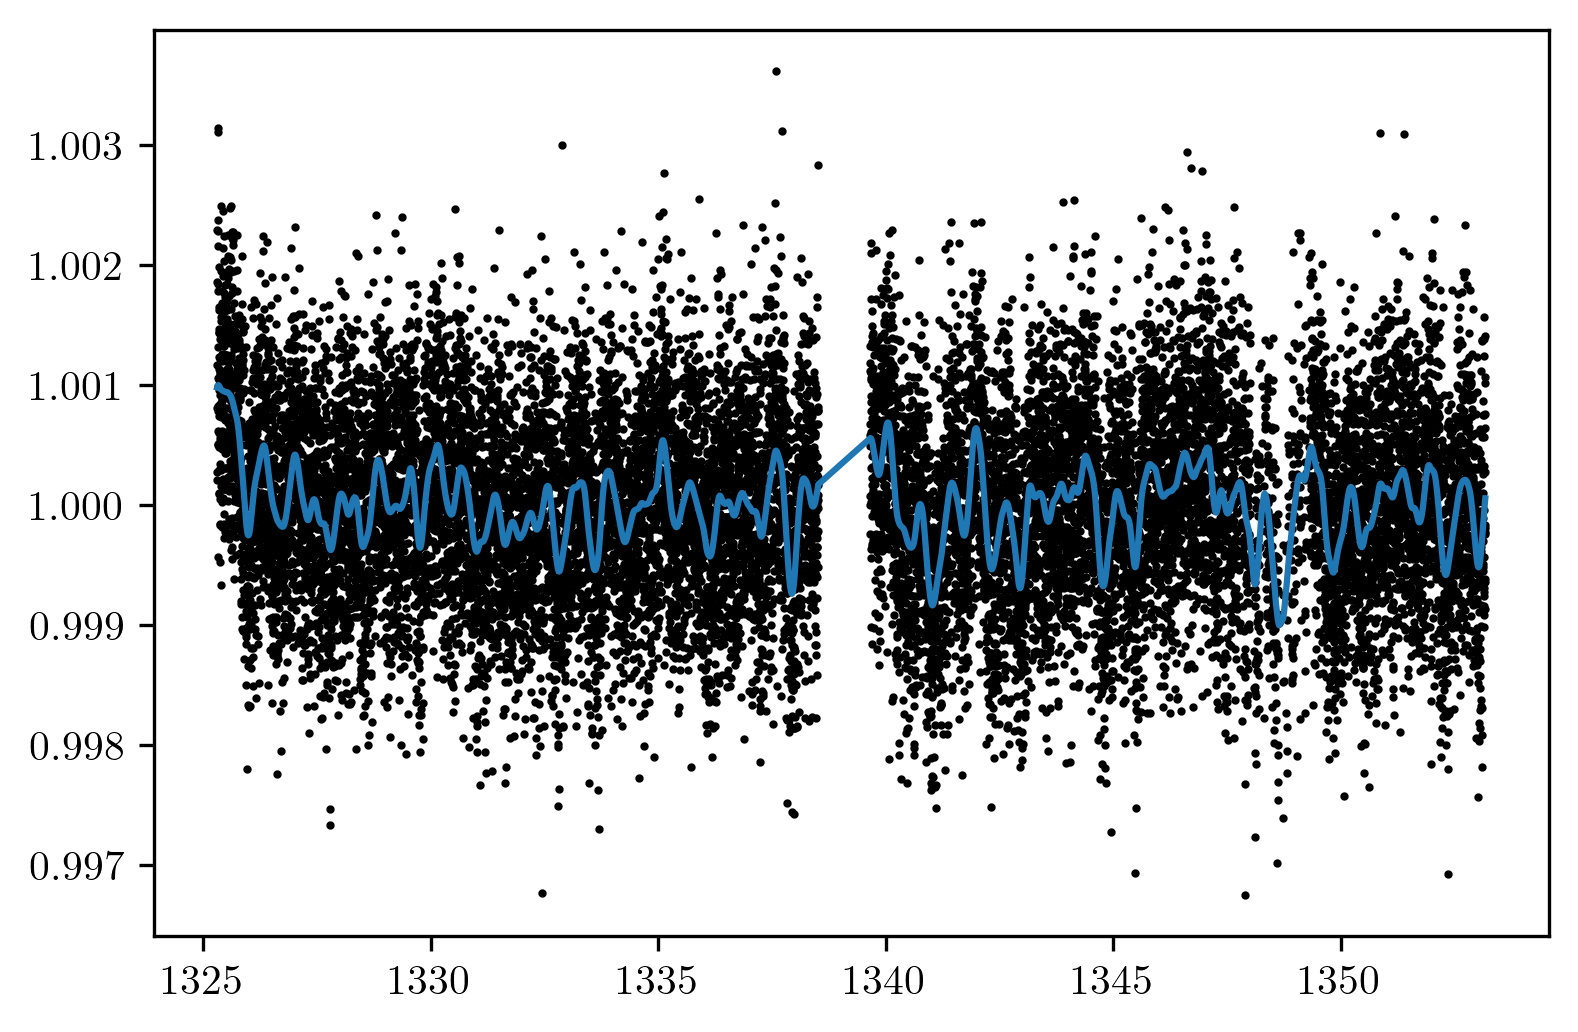

In [62]:
fig = plt.figure(dpi=300)
plt.scatter(this_time, this_flux, c='k', s=1)
plt.plot(this_time, map_soln['pred']+map_soln['mean_flux'])

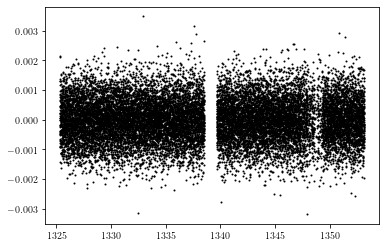

In [65]:
plt.scatter(this_time, resid_flux,c='k',s=1)

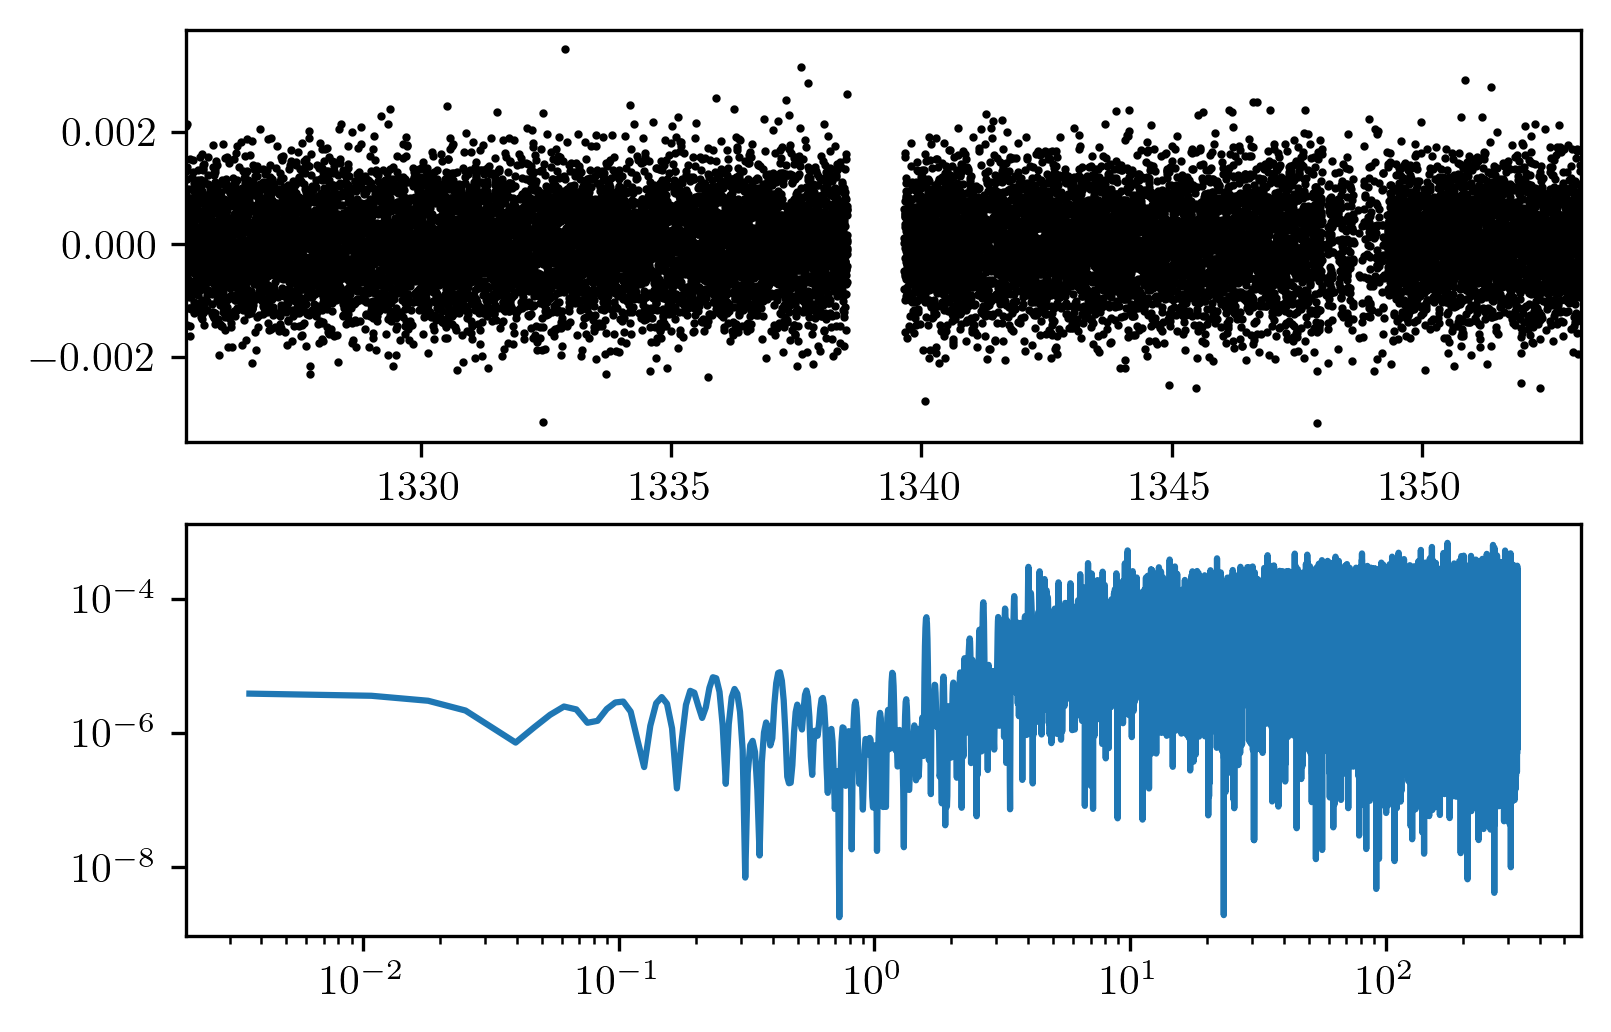

In [66]:
resid_flux = this_flux - (map_soln['pred']+map_soln['mean_flux'])

ls_resid = LombScargle(this_time,resid_flux,dy=this_err,)
freq_r,power_r=ls_resid.autopower(normalization='psd',maximum_frequency=pseudo_NF)
power_r /= len(this_time)

fig, ax = plt.subplots(2, 1, dpi=300)

ax[0].scatter(this_time, resid_flux,s=1,c='k')
ax[0].set(xlim=(this_time.min(),this_time.max()))

ax[1].loglog(freq_r, power_r)

# Let's try this with two sectors of data!

In [68]:
two_sec = lc_new[lc_new['Sector'] < 3]
two_sec

,Time,Flux,Err,Sector
77917,1325.309981,1.001858,0.000707,1
77918,1325.311370,1.000275,0.000707,1
77919,1325.312759,1.000209,0.000707,1
77920,1325.314148,1.001169,0.000707,1
77921,1325.315537,1.000812,0.000707,1
...,...,...,...,...
149668,1381.508396,1.000866,0.000709,2
149669,1381.509785,1.000120,0.000709,2
149670,1381.511174,0.999605,0.000709,2
149671,1381.512563,1.000289,0.000709,2


In [73]:
time, flux, err = lc[['Time','Flux','Err']].values.T
time

array([1325.2960926 , 1325.29748149, 1325.29887038, ..., 2389.71504062,
       2389.71642951, 2389.7178184 ])

In [82]:
def gp_multisector(lc, fs=None, amps=None, phases=None, model=None, return_var=False, thin=50):
    """
    Use PyMC3 to do a maximum likelihood fit for a GP + multiple periodic 
    signals, but now with a twist: handles multiple sectors!
    
    Inputs
    ------
    ls : `pandas.DataFrame`
        Dataframe containing the lightcurve. Must have Time, Flux, Err, and
        Sector as columns.
    fs : array-like, elements are PyMC3 distributions
        Array with frequencies to fit, default None (i.e., only the GP is fit)
    amps : array-like, elements are PyMC3 distributions
        Array with amplitudes to fit, default None (i.e., only the GP is fit)
    phases : array-like, elements are PyMC3 distributions
        Array with phases to fit, default None (i.e., only the GP is fit)
    model : `pymc3.model.Model`
        PyMC3 Model object, will fail unless given
    return_var : bool, default True
        If True, returns the variance of the GP
    thin : integer, default 50
        Calculate the variance of the GP every `thin` points.
        
    Returns
    -------
    map_soln : dict
        Contains best-fit parameters and the gp predictions
    logp : float
        The log-likelihood of the model
    bic : float
        The Bayesian Information Criterion, -2 ln P + m ln N
    var : float
        If `return_var` is True, returns the variance of the GP
    """
    
    assert model is not None, "Must provide a PyMC3 model object"
    
    time, flux, err, sectors = lc[['Time','Flux','Err','Sector']].values.T
    
    #Step 1: Mean model
    mean_flux = pm.Normal("mean_flux", mu = 1.0, sigma=np.std(flux))
    if fs is not None:
        #Making a callable for celerite
        mean_model = tt.sum([a * tt.sin(2.0*np.pi*f*time + phi) for a,f,phi in zip(amps,fs,phases)],axis=0) + mean_flux
        #And add it to the model
        pm.Deterministic("mean", mean_model)

    else:
        mean_model = mean_flux
        mean = pm.Deterministic("mean", mean_flux)
        
    #Step 2: Compute Lomb-Scargle Periodogram
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (time.max() - time.min())
    ls = LombScargle(time,flux)
    freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
    power /= len(time)
    
    #Step 3: Do the basic peridogram fit to guess nu_char and alpha_0
    popt, pcov, resid = fit_red_noise(freq, power)
    a0, tau_char, gamma, aw = popt
    nu_char = 1.0/(2*np.pi*tau_char)

    # A jitter term per sector describing excess white noise (analogous to C_w)
    jitters = [pm.Uniform(f"log_jitter_S{int(s)}", lower=np.log(aw)-15, upper=np.log(aw)+15, testval=np.log(np.median(np.abs(np.diff(flux))))) for s in np.unique(sectors)]

    # A term to describe the SLF variability, shared across sectors

    #guesses for our parameters
    omega_0_guess = 2*np.pi*nu_char
    Q_guess = 1/np.sqrt(2)
    sigma_guess = a0 * np.sqrt(omega_0_guess*Q_guess) * np.power(np.pi/2.0, 0.25)
    
    #sigma
    logsigma = pm.Uniform("log_sigma", lower=np.log(sigma_guess)-10, upper=np.log(sigma_guess)+10)
    sigma = pm.Deterministic("sigma",tt.exp(logsigma))
    
    #rho (characteristic timescale)
    logrho = pm.Uniform("log_rho", lower=np.log(0.01/nu_char), upper=np.log(100.0/nu_char))
    rho = pm.Deterministic("rho", tt.exp(logrho))
    
    nuchar = pm.Deterministic("nu_char", 1.0 / rho)
    
    #tau (damping timescale)
    logtau = pm.Uniform("log_tau", lower=np.log(0.01*2.0*Q_guess/omega_0_guess),upper=np.log(100.0*2.0*Q_guess/omega_0_guess))
    tau = pm.Deterministic("tau", tt.exp(logtau))
    
    nudamp = pm.Deterministic("nu_damp", 1.0 / tau)
    
    #We also want to track Q, as it's a good estimate of how stochastic the 
    #process is.
    Q = pm.Deterministic("Q", np.pi*tau/rho)

    kernel = terms.SHOTerm(sigma=sigma, rho=rho, tau=tau)
    
    #A number of GP objects with shared hyperparameters
    gps = [GaussianProcess(
           kernel,
           t=time[sectors==s],
           diag=err[sectors==s] ** 2.0 + tt.exp(2 * j),
           quiet=True,)
           for s,j in zip(np.unique(sectors),jitters)
        
    ]
    
    for s,gp in zip(np.unique(sectors),gps):
        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal(f"gp_S{int(s)}", observed=(flux-mean_model)[sectors==s])

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic(f"pred_S{int(s)}", gp.predict((flux-mean_model)[sectors==s]))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize()
    logp = model.logp(map_soln)
    # parameters are logtau, logsigma, logrho, mean, jitter*n_sectors, plus 3 per frequency (rho is fixed)
    base_par = 4 + len(np.unique(sectors))
    if fs is not None:
        n_par = base_par + (3.0 * len(fs))
    else:
        n_par = base_par
    bic = -2.0*logp + n_par * np.log(len(time))
    
    #compute variance as well...
    if return_var:
        eval_in_model(gp.compute(time[::thin],yerr=err[::thin]), map_soln)
        mu, var = eval_in_model(gp.predict(flux[::thin], t=time[::thin], return_var=True), map_soln)
        return map_soln, logp, bic, var
        
    return map_soln, logp, bic

In [80]:
with pm.Model() as model_m:
    map_soln, logp, bic = gp_multisector(two_sec, model=model_m)

optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter_S2.0, log_jitter_S1.0, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 208664.44846375892 -> 212406.74229555132


In [84]:
with pm.Model() as model_all:
    map_soln, logp, bic = gp_multisector(lc_new, model=model_all)

optimizing logp for variables: [log_tau, log_rho, log_sigma, log_jitter_S39, log_jitter_S38, log_jitter_S36, log_jitter_S35, log_jitter_S34, log_jitter_S33, log_jitter_S32, log_jitter_S31, log_jitter_S30, log_jitter_S29, log_jitter_S28, log_jitter_S13, log_jitter_S12, log_jitter_S11, log_jitter_S10, log_jitter_S9, log_jitter_S8, log_jitter_S6, log_jitter_S5, log_jitter_S4, log_jitter_S3, log_jitter_S2, log_jitter_S1, mean_flux]


message: Desired error not necessarily achieved due to precision loss.
logp: 2133928.4232221385 -> 2179122.8668114496
